In [ ]:
# Fix for numpy and scikit-surprise compatibility issue
!apt-get install -y python3-dev
!pip install cython --quiet
!pip install numpy==1.23.5 scikit-learn==1.3.0 --quiet
!pip install scikit-surprise --no-binary :all: --quiet

# Restart the runtime after running this cell
import os
os.kill(os.getpid(), 9)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
arviz 0.22.0 requires numpy>=1.26.0, but you have numpy 1.23.5 which is incompati

In [ ]:
!pip install scikit-learn

In [ ]:
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
import pandas as pd

users = pd.read_csv('ml-1m/users.dat', sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
users.head()



,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID','Rating','Timestamp'])
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
# --- Add Baseline Models ---
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Popularity-based rating prediction
item_avg_rating = ratings.groupby('MovieID')['Rating'].mean()
ratings['popularity_pred'] = ratings['MovieID'].map(item_avg_rating)

# User-average-based prediction
user_avg_rating = ratings.groupby('UserID')['Rating'].mean()
ratings['useravg_pred'] = ratings['UserID'].map(user_avg_rating)

print("\n--- Baseline Model Performance ---")
print("Popularity MAE:", mean_absolute_error(ratings['Rating'], ratings['popularity_pred']))
print("User Average MAE:", mean_absolute_error(ratings['Rating'], ratings['useravg_pred']))




--- Baseline Model Performance ---
Popularity MAE: 0.7787902185267612
User Average MAE: 0.8234169204814059


In [ ]:
# --- Cold-Start Evaluation for Baseline Models ---
# Identify users with few ratings (adjust threshold if needed)
user_counts = ratings['UserID'].value_counts()
cold_users = user_counts[user_counts <= 50].index

# Filter cold-start ratings
cold_ratings = ratings[ratings['UserID'].isin(cold_users)]

# Print stats
print(f"Cold-start users found: {len(cold_users)}")
print(f"Cold-start ratings found: {len(cold_ratings)}")

# Evaluate only if we have cold-start samples
if not cold_ratings.empty:
    cold_pop_mae = mean_absolute_error(cold_ratings['Rating'], cold_ratings['popularity_pred'])
    cold_useravg_mae = mean_absolute_error(cold_ratings['Rating'], cold_ratings['useravg_pred'])

    print("\n--- Cold-Start User Evaluation ---")
    print("Cold-Start Popularity MAE:", cold_pop_mae)
    print("Cold-Start User Avg MAE:", cold_useravg_mae)
else:
    print("No cold-start users with sufficient data found. Try lowering the threshold.")


Cold-start users found: 1793
Cold-start ratings found: 59238

--- Cold-Start User Evaluation ---
Cold-Start Popularity MAE: 0.8035285950815482
Cold-Start User Avg MAE: 0.8251099683355088


In [ ]:
# --- Feature Ablation Test for Baseline Models ---

print("\n--- Feature Ablation Test ---")

# Baseline: full data (already computed)
baseline_pop_mae = mean_absolute_error(ratings['Rating'], ratings['popularity_pred'])
baseline_useravg_mae = mean_absolute_error(ratings['Rating'], ratings['useravg_pred'])

# Store results
ablation_results = []

# 1. Remove 'popularity_pred' feature (simulate missing item average)
ratings_ablated_pop = ratings.drop(columns=['popularity_pred'])
try:
    mae_no_pop = mean_absolute_error(ratings['Rating'], ratings_ablated_pop['useravg_pred'])
    ablation_results.append(('No Popularity Feature', mae_no_pop))
except:
    ablation_results.append(('No Popularity Feature', 'N/A'))

# 2. Remove 'useravg_pred' feature (simulate missing user average)
ratings_ablated_useravg = ratings.drop(columns=['useravg_pred'])
try:
    mae_no_useravg = mean_absolute_error(ratings['Rating'], ratings_ablated_useravg['popularity_pred'])
    ablation_results.append(('No User Average Feature', mae_no_useravg))
except:
    ablation_results.append(('No User Average Feature', 'N/A'))

# 3. Remove both (simulate cold-start baseline only)
try:
    ablation_results.append(('No Features (Random Guess)', ratings['Rating'].mean()))
except:
    ablation_results.append(('No Features (Random Guess)', 'N/A'))

# Print Results
print(f"\nBaseline Popularity MAE: {baseline_pop_mae:.4f}")
print(f"Baseline User Average MAE: {baseline_useravg_mae:.4f}")
print("\nFeature Ablation Results:")
for feature, mae in ablation_results:
    print(f"{feature}: MAE = {mae}")


--- Feature Ablation Test ---

Baseline Popularity MAE: 0.7788
Baseline User Average MAE: 0.8234

Feature Ablation Results:
No Popularity Feature: MAE = 0.8234169204814059
No User Average Feature: MAE = 0.7787902185267612
No Features (Random Guess): MAE = 3.581564453029317


In [ ]:
# --- Matrix Factorization using SVD (ALS-like) ---

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import mae

print("\n--- Matrix Factorization using SVD ---")

# Prepare data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

# Split into train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train model
model = SVD()
model.fit(trainset)

# Predict and evaluate
predictions = model.test(testset)
mf_mae = mae(predictions)

print(f"\nMatrix Factorization (SVD) MAE: {mf_mae:.4f}")



--- Matrix Factorization using SVD ---
MAE:  0.6850

Matrix Factorization (SVD) MAE: 0.6850


In [ ]:
from collections import defaultdict
import math

def precision_recall_ndcg(predictions, k=10):
    user_topk = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_topk[uid].append((est, iid, true_r))

    recall_sum, ndcg_sum, total_users = 0, 0, 0
    for uid, user_ratings in user_topk.items():
        user_ratings.sort(reverse=True)
        top_k = user_ratings[:k]

        hits = sum(1 for _, _, true_r in top_k if true_r >= 4)
        relevant_count = sum(1 for _, _, r in user_ratings if r >= 4)
        if relevant_count == 0:
            continue  # skip users with no relevant ground truth

        recall = hits / relevant_count

        dcg = sum((1 / math.log2(i + 2)) if r >= 4 else 0 for i, (_, _, r) in enumerate(top_k))
        idcg = sum(1 / math.log2(i + 2) for i in range(min(k, relevant_count)))
        ndcg = dcg / idcg if idcg > 0 else 0

        recall_sum += recall
        ndcg_sum += ndcg
        total_users += 1

    if total_users == 0:
        return 0.0, 0.0

    return recall_sum / total_users, ndcg_sum / total_users


In [ ]:
recall_10, ndcg_10 = precision_recall_ndcg(predictions, k=10)
print(f"Recall@10: {recall_10:.4f}")
print(f"NDCG@10: {ndcg_10:.4f}")


Recall@10: 0.6398
NDCG@10: 0.8709


In [ ]:
print(type(predictions))
print(type(predictions[0]))
print(predictions[0])


<class 'list'>
<class 'numpy.float32'>
3.5727277


In [ ]:
from surprise import KNNBasic

# Item-based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': False}
model_item = KNNBasic(sim_options=sim_options)
model_item.fit(trainset)
predictions_item = model_item.test(testset)
mae_item = mae(predictions_item)

# User-based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}
model_user = KNNBasic(sim_options=sim_options)
model_user.fit(trainset)
predictions_user = model_user.test(testset)
mae_user = mae(predictions_user)

print(f"Item-based KNN MAE: {mae_item:.4f}")
print(f"User-based KNN MAE: {mae_user:.4f}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7794
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7713
Item-based KNN MAE: 0.7794
User-based KNN MAE: 0.7713


In [ ]:
predictions = model.test(testset)
mf_mae = mae(predictions)

MAE:  0.6850


In [ ]:
knn_predictions = model.test(testset)
recall_knn, ndcg_knn = precision_recall_ndcg(knn_predictions, k=10)
print(f"KNN Recall@10: {recall_knn:.4f}")
print(f"KNN NDCG@10: {ndcg_knn:.4f}")


KNN Recall@10: 0.6398
KNN NDCG@10: 0.8709


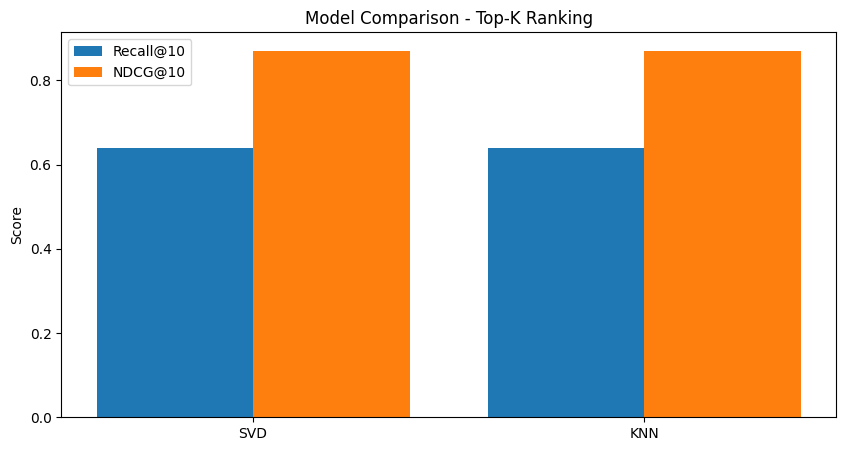

In [ ]:
import matplotlib.pyplot as plt

models = ['SVD', 'KNN']
recalls = [recall_10, recall_knn]
ndcgs = [ndcg_10, ndcg_knn]

x = range(len(models))
plt.figure(figsize=(10,5))

plt.bar(x, recalls, width=0.4, label='Recall@10', align='center')
plt.bar([i + 0.4 for i in x], ndcgs, width=0.4, label='NDCG@10', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.ylabel('Score')
plt.title('Model Comparison - Top-K Ranking')
plt.legend()
plt.show()


In [ ]:
from collections import defaultdict
import numpy as np

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Compute Recall@10 and NDCG@10
def precision_recall_ndcg_at_k(predictions, k=10):
    hit = 0
    total = 0
    ndcg_total = 0

    top_n = get_top_n(predictions, n=k)
    for uid, user_ratings in top_n.items():
        actual = [iid for (uid_, iid, true_r, est, _) in predictions if uid_ == uid and true_r >= 4.0]  # relevant items
        recommended = [iid for (iid, _) in user_ratings]

        if actual:
            hits = len(set(recommended) & set(actual))
            hit += hits
            total += len(actual)

            dcg = 0.0
            idcg = 0.0
            for i, iid in enumerate(recommended):
                if iid in actual:
                    dcg += 1.0 / np.log2(i + 2)
            for i in range(min(len(actual), k)):
                idcg += 1.0 / np.log2(i + 2)
            ndcg_total += dcg / idcg if idcg > 0 else 0.0

    recall = hit / total if total else 0
    ndcg = ndcg_total / len(top_n)
    print(f"Recall@{k}: {recall:.4f}")
    print(f"NDCG@{k}: {ndcg:.4f}")

# Run on SVD predictions
precision_recall_ndcg_at_k(predictions, k=10)


Recall@10: 0.3568
NDCG@10: 0.8628


In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n_svd = get_top_n(predictions, n=5)

# Print sample recommendations
for uid, user_ratings in list(top_n_svd.items())[:5]:
    print(f"\nUser {uid} recommended items: {[iid for (iid, _) in user_ratings]}")



User 1841 recommended items: [318, 1247, 34, 1784, 296]

User 3715 recommended items: [2716, 1270, 3114, 3793, 2096]

User 2002 recommended items: [903, 3307, 930, 3801, 1278]

User 3332 recommended items: [223, 2692, 1198, 3160, 1961]

User 3576 recommended items: [356, 3801, 954, 1278, 553]


In [ ]:
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', encoding='ISO-8859-1', names=['MovieID','Title','Genres'])
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Choose a sample user from top_n_svd
sample_user = list(top_n_svd.keys())[0]  # or choose manually like sample_user = 1841
print(f"\n Personalized Case Study for User {sample_user}")
# Print model's top 5 recommendations
print("Model Recommendations:")
recommended = [iid for (iid, _) in top_n_svd[sample_user]]
print(movies[movies['MovieID'].isin(recommended)][['Title', 'Genres']])
# Print user's top 5 historically rated movies
user_ratings = ratings[ratings['UserID'] == sample_user]
top_actual = user_ratings.sort_values(by='Rating', ascending=False).head(5)
print("\n User's Top Rated Movies:")
print(top_actual.merge(movies, on='MovieID')[['Title', 'Rating', 'Genres']])


 Personalized Case Study for User 1841
Model Recommendations:
                                 Title                   Genres
33                         Babe (1995)  Children's|Comedy|Drama
293                Pulp Fiction (1994)              Crime|Drama
315   Shawshank Redemption, The (1994)                    Drama
1227              Graduate, The (1967)            Drama|Romance
1726         As Good As It Gets (1997)             Comedy|Drama

 User's Top Rated Movies:
                              Title  Rating                       Genres
0           Sixth Sense, The (1999)       5                     Thriller
1                Sling Blade (1996)       5               Drama|Thriller
2                Toy Story 2 (1999)       5  Animation|Children's|Comedy
3  Shawshank Redemption, The (1994)       5                        Drama
4               Falling Down (1993)       5                 Action|Drama


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['Popularity', 'User Avg', 'Item-KNN', 'User-KNN', 'SVD'],
    'MAE': [baseline_pop_mae, baseline_useravg_mae, mae_item, mae_user, mf_mae]
})
print("\nModel Performance Summary:")
display(results_df.sort_values(by='MAE'))



Model Performance Summary:


,Model,MAE
4,SVD,0.685026
3,User-KNN,0.771333
0,Popularity,0.778790
2,Item-KNN,0.779394
1,User Avg,0.823417


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize timestamp to [0, 1] to create a recency score
scaler = MinMaxScaler()
ratings['Recency'] = scaler.fit_transform(ratings[['Timestamp']])

# Optional: print a few rows to verify
print(ratings[['Timestamp', 'Recency']].head())


   Timestamp   Recency
0  978300760  0.240631
1  978302109  0.240646
2  978301968  0.240645
3  978300275  0.240626
4  978824291  0.246465


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("Users Data:")
print(users.describe())
print("\nMovies Data:")
print(movies.describe())
print("\nRatings Data:")
print(ratings.describe())


print("\nMissing Values in Users Data:")
print(users.isnull().sum())
print("\nMissing Values in Movies Data:")
print(movies.isnull().sum())
print("\nMissing Values in Ratings Data:")
print(ratings.isnull().sum())

Users Data:
            UserID          Age   Occupation
count  6040.000000  6040.000000  6040.000000
mean   3020.500000    30.639238     8.146854
std    1743.742145    12.895962     6.329511
min       1.000000     1.000000     0.000000
25%    1510.750000    25.000000     3.000000
50%    3020.500000    25.000000     7.000000
75%    4530.250000    35.000000    14.000000
max    6040.000000    56.000000    20.000000

Movies Data:
           MovieID
count  3883.000000
mean   1986.049446
std    1146.778349
min       1.000000
25%     982.500000
50%    2010.000000
75%    2980.500000
max    3952.000000

Ratings Data:
             UserID       MovieID        Rating     Timestamp  \
count  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06   
mean   3.024512e+03  1.865540e+03  3.581564e+00  9.722437e+08   
std    1.728413e+03  1.096041e+03  1.117102e+00  1.215256e+07   
min    1.000000e+00  1.000000e+00  1.000000e+00  9.567039e+08   
25%    1.506000e+03  1.030000e+03  3.000000e+00  9.653026e

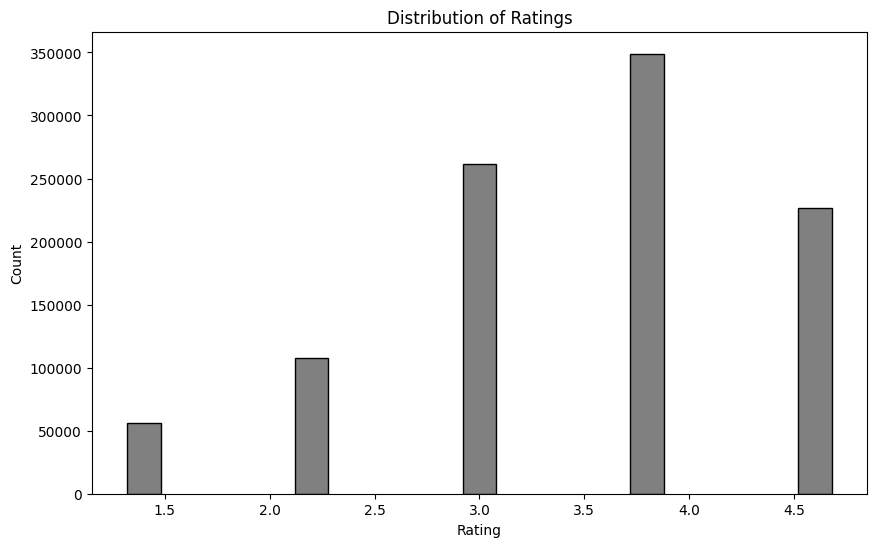

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(ratings['Rating'], bins=5, edgecolor='black', align='mid', rwidth=0.2,color="gray")  # Adjust the rwidth parameter
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


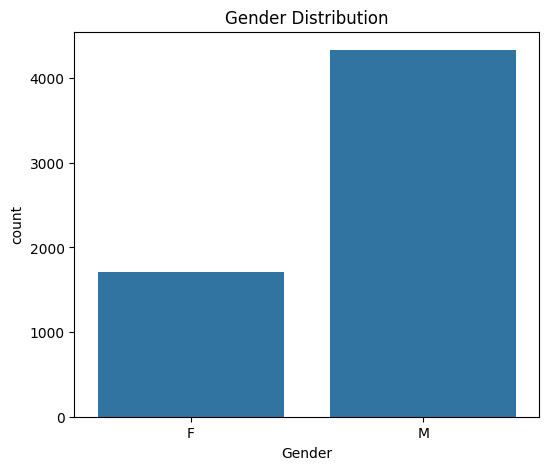

In [ ]:
plt.figure(figsize=(6,5))
sns.countplot(data=users, x='Gender')
plt.title('Gender Distribution')
plt.show()


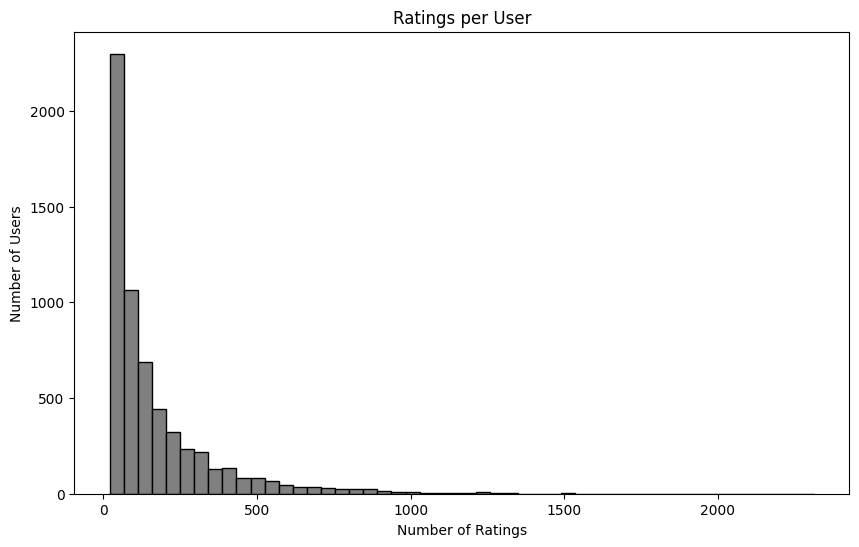

In [ ]:
import matplotlib.pyplot as plt

ratings_per_user = ratings.groupby('UserID').size()

plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, edgecolor='black',color="gray")
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


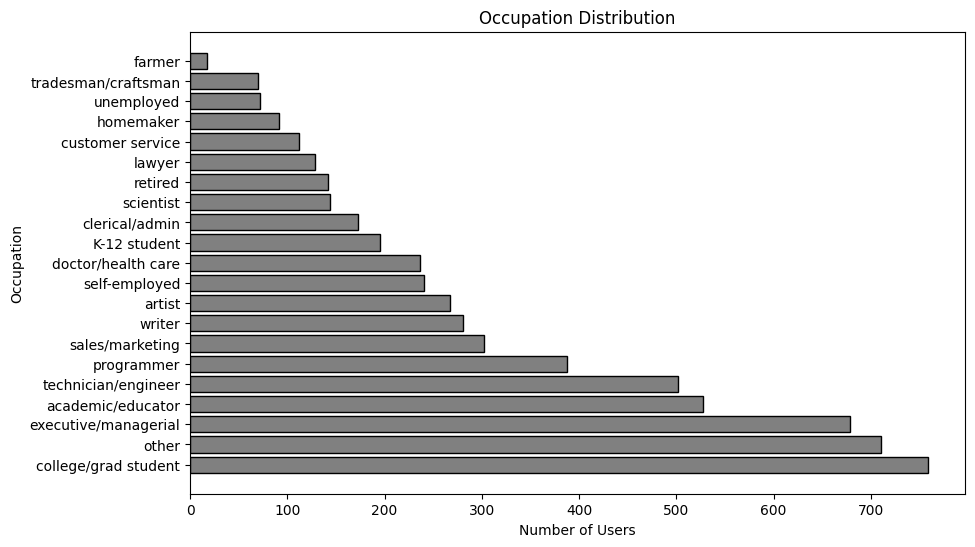

In [ ]:
import matplotlib.pyplot as plt

occupation_map = {
    0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin", 4: "college/grad student",
    5: "customer service", 6: "doctor/health care", 7: "executive/managerial", 8: "farmer",
    9: "homemaker", 10: "K-12 student", 11: "lawyer", 12: "programmer", 13: "retired",
    14: "sales/marketing", 15: "scientist", 16: "self-employed", 17: "technician/engineer",
    18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}

users['Occupation_name'] = users['Occupation'].map(occupation_map)

plt.figure(figsize=(10, 6))
plt.barh(users['Occupation_name'].value_counts().index, users['Occupation_name'].value_counts(),edgecolor='black',color="gray")
plt.title('Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()


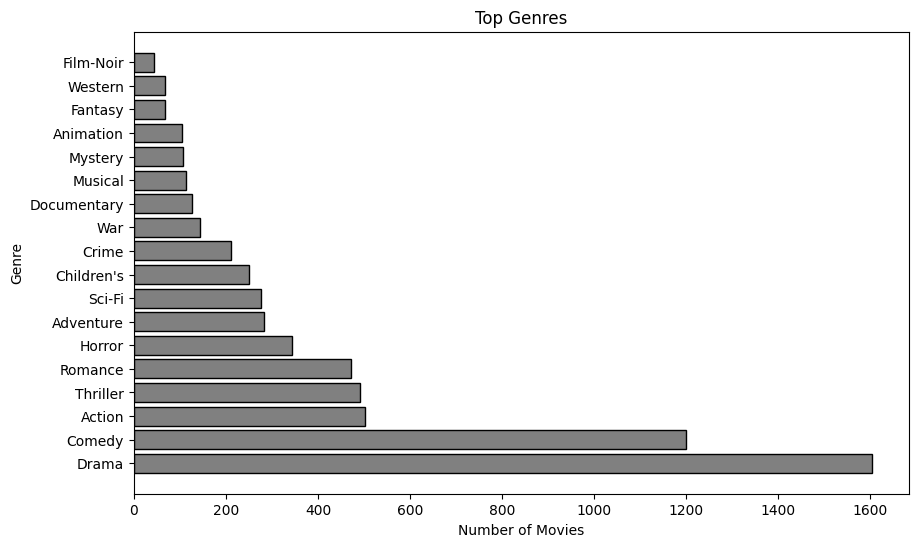

In [ ]:
import matplotlib.pyplot as plt

all_genres = movies['Genres'].str.split('|', expand=True).stack().reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.barh(all_genres.value_counts().index, all_genres.value_counts(), edgecolor='black',color="gray")
plt.title('Top Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


In [ ]:
movie_stats = ratings.groupby('MovieID').agg({'Rating': [np.size, np.mean]})
top_rated_movies = movie_stats['Rating'][(movie_stats['Rating']['size'] >= 500)].sort_values(by='mean', ascending=False).merge(movies, left_index=True, right_on='MovieID')
top_rated_movies[['Title', 'mean', 'size']].head(10)


,Title,mean,size
1950,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510,628
315,"Shawshank Redemption, The (1994)",4.554558,2227
847,"Godfather, The (1972)",4.524966,2223
735,"Close Shave, A (1995)",4.520548,657
49,"Usual Suspects, The (1995)",4.517106,1783
523,Schindler's List (1993),4.510417,2304
1132,"Wrong Trousers, The (1993)",4.507937,882
1180,Raiders of the Lost Ark (1981),4.477725,2514
892,Rear Window (1954),4.476190,1050
257,Star Wars: Episode IV - A New Hope (1977),4.453694,2991


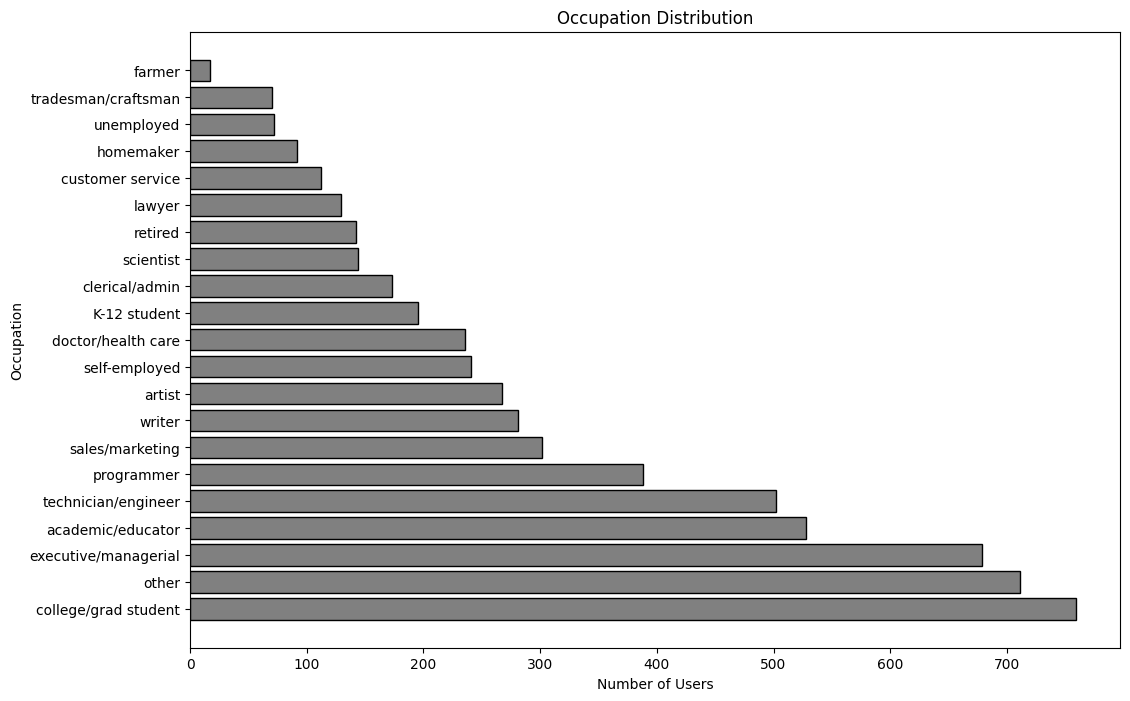

In [ ]:
import matplotlib.pyplot as plt

occupation_map = {
    0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin", 4: "college/grad student",
    5: "customer service", 6: "doctor/health care", 7: "executive/managerial", 8: "farmer",
    9: "homemaker", 10: "K-12 student", 11: "lawyer", 12: "programmer", 13: "retired",
    14: "sales/marketing", 15: "scientist", 16: "self-employed", 17: "technician/engineer",
    18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}

users['Occupation_name'] = users['Occupation'].map(occupation_map)

plt.figure(figsize=(12, 8))
plt.barh(users['Occupation_name'].value_counts().index, users['Occupation_name'].value_counts(),edgecolor='black',color="gray")
plt.title('Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()


In [ ]:
users = users.drop_duplicates()
movies = movies.drop_duplicates()
ratings = ratings.drop_duplicates()

In [ ]:
print("Users shape:", users.shape)
print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)

Users shape: (6040, 6)
Movies shape: (3883, 3)
Ratings shape: (1000209, 7)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClientDataset(Dataset):
    def __init__(self, users, movies, ratings):

        self.data = ratings.merge(users, on='UserID').merge(movies, on='MovieID')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return (
            row['UserID'],
            row['MovieID'],
            torch.tensor(mlb.transform([row['Genres'].split('|')])[0], dtype=torch.float),
            torch.tensor(occupation_encoder.transform([[row['Occupation']]])[0], dtype=torch.float),
            torch.tensor(row['Age_encoded'], dtype=torch.long),
            row['Gender_encoded'],
            row['Rating']
        )

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['Genres'].str.split('|'))
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=movies.index)


occupation_encoder = OneHotEncoder(sparse_output=False)
occupations_encoded = occupation_encoder.fit_transform(users[['Occupation']])
occupations_df = pd.DataFrame(occupations_encoded, columns=occupation_encoder.get_feature_names_out(['Occupation']), index=users.index)

gender_encoder = LabelEncoder()
users['Gender_encoded'] = gender_encoder.fit_transform(users['Gender'])


age_encoder = LabelEncoder()
users['Age_encoded'] = age_encoder.fit_transform(users['Age'])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ExpandedRecommender(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim, num_genres, num_occupations, num_ages, num_genders=2):
        super(ExpandedRecommender, self).__init__()


        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies + 1, embedding_dim)
        self.age_embedding = nn.Embedding(num_ages, embedding_dim)
        self.gender_embedding = nn.Embedding(2,embedding_dim)

        self.genre_layer = nn.Linear(num_genres, embedding_dim)
        self.occupation_layer = nn.Linear(num_occupations, embedding_dim)


        self.fc1 = nn.Linear(embedding_dim * 6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, user_ids, movie_ids, genres, occupations, ages, genders):
        user_embedded = self.user_embedding(user_ids)
        movie_embedded = self.movie_embedding(movie_ids)
        age_embedded = self.age_embedding(ages)
        gender_embedded = self.gender_embedding(genders)


        genres = genres.float()
        occupations = occupations.float()

        genre_embedded = F.relu(self.genre_layer(genres))
        occupation_embedded = F.relu(self.occupation_layer(occupations))

        x = torch.cat((user_embedded, movie_embedded, genre_embedded, occupation_embedded, age_embedded, gender_embedded), 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x.squeeze()


In [ ]:
from sklearn.model_selection import train_test_split

all_train_data, test_data = train_test_split(ratings, test_size=0.1, random_state=42)

num_clients = 10
client_data_split = np.array_split(all_train_data, num_clients)
client_datasets = [ClientDataset(users, movies, data) for data in client_data_split]
client_loaders = [DataLoader(dataset, batch_size=256, shuffle=True) for dataset in client_datasets]

test_dataset = ClientDataset(users, movies, test_data)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
all_train_data

,UserID,MovieID,Rating,Timestamp,popularity_pred,useravg_pred,Recency
647085,3894,2750,1,965791718,3.698246,3.761006,0.101256
130254,843,2791,4,975358667,3.971115,3.944444,0.207851
232200,1408,2006,2,974762606,3.561546,3.139706,0.201209
61200,412,3301,3,976651610,3.378738,4.401261,0.222257
477192,2929,832,4,971642889,3.478723,3.925414,0.166450
...,...,...,...,...,...,...,...
259178,1586,1077,5,974735719,3.979839,4.424096,0.200910
365838,2129,2700,5,974643199,3.760441,3.271709,0.199879
131932,854,3102,3,975355597,3.643443,3.027668,0.207816
671155,4033,3479,5,965525805,3.673432,3.767372,0.098293


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from collections import OrderedDict
import copy

In [ ]:
print("Max UserID in Train:", all_train_data['UserID'].max())
print("Max UserID in Test:", test_data['UserID'].max())
print("Max MovieID in Train:", all_train_data['MovieID'].max())
print("Max MovieID in Test:", test_data['MovieID'].max())

Max UserID in Train: 6040
Max UserID in Test: 6040
Max MovieID in Train: 3952
Max MovieID in Test: 3952


In [ ]:
print("Max UserID in Train:", all_train_data['UserID'].max())
print("Max MovieID in Train:", all_train_data['MovieID'].max())

print("Max UserID in Test:", test_data['UserID'].max())
print("Max MovieID in Test:", test_data['MovieID'].max())

Max UserID in Train: 6040
Max MovieID in Train: 3952
Max UserID in Test: 6040
Max MovieID in Test: 3952


In [ ]:
import os

model_dir = './saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
import copy
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,r2_score,mean_squared_error,mean_squared_log_error
import numpy as np

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



def average_weights(client_models):
    average_model_weights = OrderedDict()
    for k in client_models[0].state_dict().keys():
        average_model_weights[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(num_clients)], 0).mean(0)
    return average_model_weights


global_model = ExpandedRecommender(
    num_users=users['UserID'].max()+1,
    num_movies=ratings['MovieID'].max()+1,
    embedding_dim=50,
    num_genres=len(mlb.classes_),
    num_occupations=len(occupation_encoder.categories_[0]),
    num_ages=len(age_encoder.classes_)+1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(global_model.parameters(), lr=0.001)
epochs = 1
rounds = 1
num_clients = 10


client_losses = {i: [] for i in range(num_clients)}
global_losses = []

client_accuracies = {i: [] for i in range(num_clients)}
global_accuracies = []

client_mae = {i: [] for i in range(num_clients)}
global_maes = []

acc = []
c_loss = []
model_dir = 'model_dir'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for round in range(rounds):
    client_models = [copy.deepcopy(global_model) for _ in range(num_clients)]
    for client in range(num_clients):
        optimizer = torch.optim.Adam(client_models[client].parameters(), lr=0.001)
        los = []
        for epoch in range(epochs):
            client_models[client].train()
            running_loss = 0.0

            for batch_data in client_loaders[client]:
                user_ids, movie_ids, genres, occupations, ages, genders, rating = [item.to(device) for item in batch_data]
                optimizer.zero_grad()
                outputs = client_models[client](user_ids, movie_ids, genres, occupations, ages, genders)
                loss = criterion(outputs, rating.float())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(client_loaders[client])
            print(f"Client {client+1} - Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
            client_losses[client].append(epoch_loss)
            los.append(epoch_loss)

            torch.save(client_models[client].state_dict(), os.path.join(model_dir, f'client_{client+1}_round_{round+1}.pth'))
        c_loss.append(los)
    for client in range(num_clients):
        predictions = []
        true_labels = []
        client_models[client].eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data in client_loaders[client]:
                user_ids, movie_ids, genres, occupations, ages, genders, rating = [item.to(device) for item in data]
                outputs = client_models[client](user_ids, movie_ids, genres, occupations, ages, genders)
                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(rating.cpu().numpy())

        mae = mean_absolute_error(true_labels, predictions)
        a = mean_absolute_percentage_error(true_labels,predictions)
        b = r2_score(true_labels,predictions)
        c = mean_squared_error(true_labels,predictions)
        d = rmse_score(true_labels,predictions)
        #e = mean_squared_log_error(true_labels,predictions)
        acc.append([mae,a,b,c,d])
        client_mae[client].append(mae)
    global_weights = average_weights(client_models)
    global_model.load_state_dict(global_weights)

    predictions = []
    true_labels = []
    global_model.eval()
    with torch.no_grad():
        for batch_data in test_loader:
            user_ids, movie_ids, genres, occupations, ages, genders, rating = [item.to(device) for item in batch_data]
            outputs = global_model(user_ids, movie_ids, genres, occupations, ages, genders)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(rating.cpu().numpy())

    global_mae = mean_absolute_error(true_labels, predictions)
    global_maes.append(global_mae)
    print(f"After Round {round+1}, Global Model Test MAE: {global_mae:.4f}")

Client 1 - Epoch 1, Loss: 1.3747
Client 2 - Epoch 1, Loss: 1.3398
Client 3 - Epoch 1, Loss: 1.3405
Client 4 - Epoch 1, Loss: 1.3477
Client 5 - Epoch 1, Loss: 1.3529
Client 6 - Epoch 1, Loss: 1.3498
Client 7 - Epoch 1, Loss: 1.3474
Client 8 - Epoch 1, Loss: 1.3560
Client 9 - Epoch 1, Loss: 1.3415
Client 10 - Epoch 1, Loss: 1.3525
After Round 1, Global Model Test MAE: 0.8639


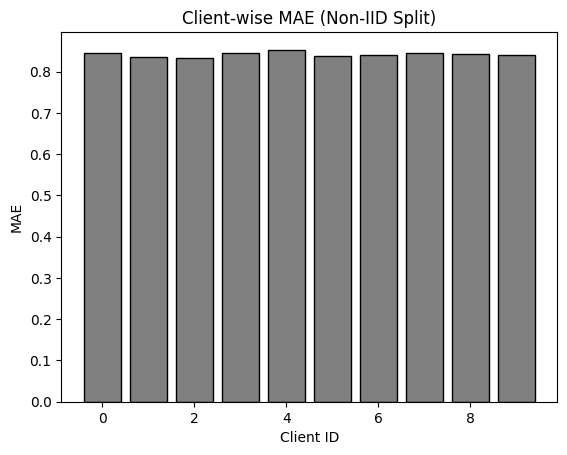

In [ ]:
import matplotlib.pyplot as plt

client_ids = list(client_mae.keys())
maes = [client_mae[i][-1] for i in client_ids]

plt.bar(client_ids, maes, color='gray', edgecolor='black')
plt.xlabel("Client ID")
plt.ylabel("MAE")
plt.title("Client-wise MAE (Non-IID Split)")
plt.show()


In [ ]:
acc

[[0.8449503771406115,
  0.3455136759896934,
  0.13442522299957071,
  1.0942297388830524,
  1.0460543670780464],
 [0.8348668278952746,
  0.3413022133199404,
  0.1380238274645752,
  1.0724910286540925,
  1.035611427444721],
 [0.8319624772353272,
  0.3436826990714705,
  0.13324353116317256,
  1.0750124975031743,
  1.0368280944800707],
 [0.8440510028164943,
  0.34150259083296086,
  0.13367276608965872,
  1.081875064685766,
  1.0401322342307087],
 [0.8528322254004156,
  0.3352300295462704,
  0.11864436845582915,
  1.100011283478697,
  1.0488142273437642],
 [0.8374727287925374,
  0.3474638221819698,
  0.12327072954629137,
  1.0929848463387861,
  1.0454591557487007],
 [0.8411104416823127,
  0.34116901031847763,
  0.1313625992040649,
  1.0826263214997636,
  1.0404933068020012],
 [0.8437468294532207,
  0.3434089309642859,
  0.130306648063222,
  1.0864392482989527,
  1.0423239651370166],
 [0.84136531806908,
  0.3377610376320998,
  0.13636433659011749,
  1.0758341740178932,
  1.0372242640904104],

In [ ]:
data = [acc, c_loss]
data = list(map(list, zip(*data)))
column_names = ['Accuracy', 'Train Losses']
df1 = pd.DataFrame(data, columns=column_names)
df1.to_csv('results_ff.csv')

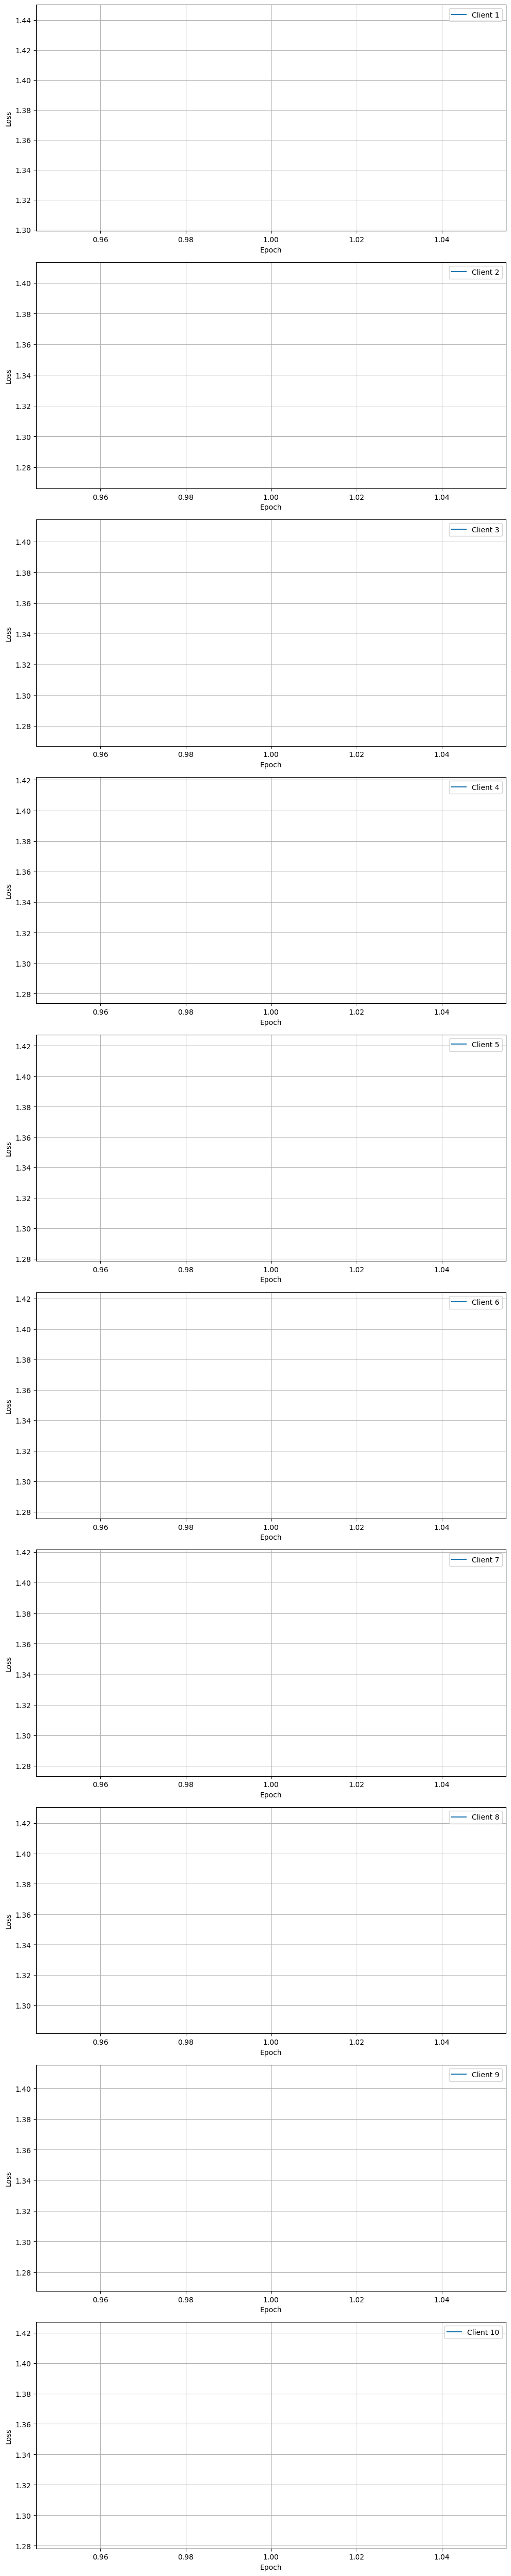

In [ ]:
fig, axs = plt.subplots(num_clients, 1, figsize=(10, 5 * num_clients))
for client, losses in client_losses.items():
    if not losses:
        print(f"No losses recorded for client {client + 1}. Skipping...")
        continue
    axs[client].plot(range(1, epochs * rounds + 1), losses, label=f'Client {client + 1}')
    axs[client].set(xlabel='Epoch', ylabel='Loss')
    axs[client].legend()
    axs[client].grid(True)
plt.tight_layout()
plt.show()


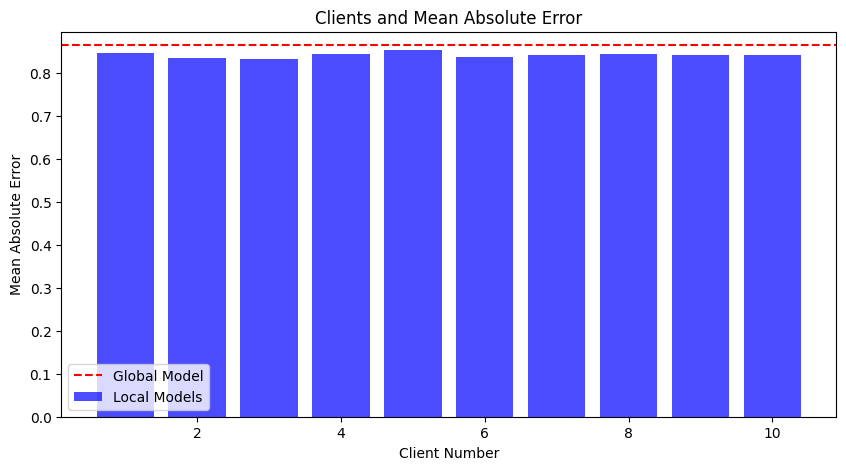

In [ ]:
clients = list(range(1, num_clients + 1))
final_maes = [maes[-1] for maes in client_mae.values()]
plt.figure(figsize=(10, 5))
plt.bar(clients, final_maes, color='blue', alpha=0.7, label='Local Models')
plt.axhline(y=global_maes[-1], color='r', linestyle='--', label='Global Model')
plt.xlabel('Client Number')
plt.ylabel('Mean Absolute Error')
plt.title('Clients and Mean Absolute Error')
plt.legend()
plt.show()


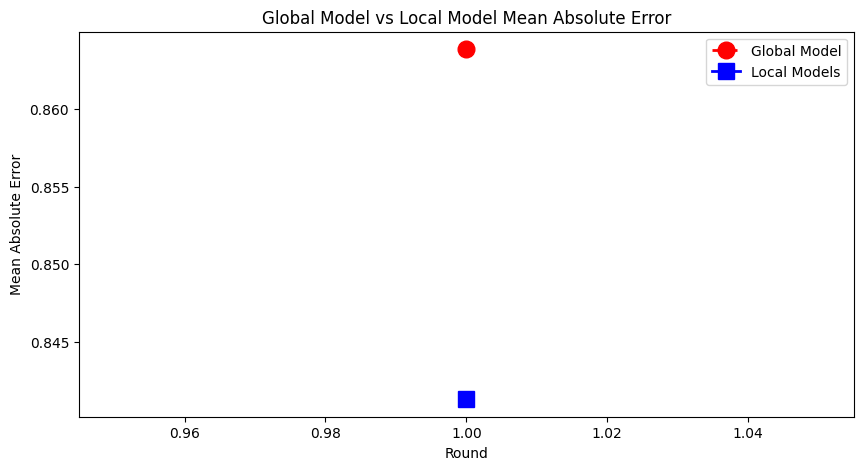

In [ ]:
import numpy as np  # Ensure that numpy is imported

rounds_list = list(range(1, rounds + 1))
plt.figure(figsize=(10, 5))

plt.plot(rounds_list, global_maes, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Global Model')

local_avg_mae = [np.mean([client_mae[client][i] for client in range(num_clients)]) for i in range(rounds)]
plt.plot(rounds_list, local_avg_mae, color='blue', marker='s', linestyle='solid', linewidth=2, markersize=12, label='Local Models')

plt.xlabel('Round')
plt.ylabel('Mean Absolute Error')
plt.title('Global Model vs Local Model Mean Absolute Error')
plt.legend()
plt.show()
